In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Environment
### Initial values: 

1. 5x5 grid world environment with initial position at (0,0) and goal position at (4,4), which is a terminal state.
2. Holes/negative reward states are at 3 positions, which are also terminal states with reward -2.
3. Each step gives a reward of -1 except for the terminal states.
4. The goal state gives a positive reward of 5.
5. Environment will be Deterministic by default, unless specified at the initialisation with "stochastic = True"
6. Steps performed in the stochastic environment will be given as P(Best action) = 0.75 and P(Random action) = 0.25




In [2]:
class gridEnvironment():
    
    #initialises a 5x5 environment
    def __init__(self, stochastic = False):
        self.dimensions = tuple([5,5])
        self.states = np.full(self.dimensions, -1)
        self.goal = tuple([4,4])
        self.hole1 = tuple([2,0])
        self.hole2 = tuple([4,1])
        self.hole3 = tuple([1,3])
        self.states[self.goal] = 5
        self.states[self.hole1] = -2
        self.states[self.hole2] = -2
        self.states[self.hole3] = -2
        self.rewards =self.states.flatten()
        self.final_rewards = []
        self.stochastic = stochastic
        self.agent_pos = tuple([0,0])
        self.states[self.agent_pos] = 10
       
        
    #initialises the environment to its initial state
    def reset(self):
        self.__init__()
    
    ## takes in all the states, current state and the action expected
    ## and returns the next index and the reward!
    def step(self, s, a):
        done = False
        if(s == 24 or s == 10 or s == 21 or s ==8):
            index = s
            done = True
        else:
            xval, yval = get_cooridnates(s)
            
            if(self.stochastic):
                if(np.random.uniform() > 0.75):
                    a = np.random.randint(4) 
            
            if(a == 0):
                if xval>0:
                    xval -=1 #up
            elif(a == 1):
                if yval<4:
                    yval+=1  #right
            elif(a == 2):
                if xval<4:
                    xval += 1  #down
            elif(a == 3):
                if yval>0:
                    yval -= 1  #left
            
            index = get_index(xval,yval)
            
            if(index == 24 or index == 10 or index == 21 or index == 8):
                done = True
       
        return index, self.rewards[index], done
    
    #get the initial state for Qlearning
    def get_initial_state(self):
        return np.random.randint(self.rewards.shape[0])
    #show the environment
    def render(self):
        plt.imshow(self.states)

# QLearning:
### HyperParameters:
1. Gamma = 0.85 
2. Alpha = 0.008 
3. Epsilon = 0.99 
4. Epsilon decay rate = 0.99

In [3]:
class Qlearning:
    
    def __init__(self, n_states):
        self.actionspace = np.arange(4)
        self.Qtable = np.zeros([n_states, 4])
        self.gamma = 0.85 #Discount factor
        self.alpha = 0.099 #Learning rate
        self.epsilon = 0.99 #Exploration vs Exploitation
        self.decay = 0.995 
        self.epsilon_values = []
    
    #update the Qtable with the new values as the agent learns
    def update_table(self, s, a, r, s_prime):
        a_prime = np.argmax(self.Qtable[s_prime])
        self.Qtable[s][a] = self.Qtable[s][a] + self.alpha * (r + self.gamma*self.Qtable[s_prime][a_prime] - self.Qtable[s][a])
    
    #get the next action the agent should take based on the Qtable
    def get_next_action(self, s, stochastic = False):
        a_vals = self.Qtable[s]
        if stochastic == False:
            if(np.random.uniform() > (1 - self.epsilon)):
                a_prime = np.random.randint(4)
            else:
                a_prime = np.argmax(a_vals)
                
        else:
            a_prime = np.random.randint(4)
            
        if(self.epsilon > 0.00000001):
            self.epsilon = self.epsilon * self.decay
            self.epsilon_values.append(self.epsilon)
        elif(self.epsilon < 0.00000001):
            self.epsilon = 0   
            
        return a_prime
    
    #epsilon decay plot
    def plot_epsilon_decay(self):
        plt.ylabel("Epsilon")
        plt.xlabel("Epsisode")
        plt.plot(self.epsilon_values)
        

# Agent:
###### The agent initially learns for 500 epochs, then uses that learnt Qtable to find the path in the environment.

In [4]:
class Agent:
    
    def __init__(self, env_dimensions, number_of_actions):
        self.env_dimensions = env_dimensions
        self.number_of_actions = number_of_actions
        self.Qtable = np.zeros([self.env_dimensions, self.number_of_actions])
        self.epochs = 500
        self.final_reward = []
        self.stochastic = False
        
    #Learning the environment
    def learn(self, env):
        Qlearn = Qlearning(self.env_dimensions)
        self.stochastic = env.stochastic

        for i in range(self.epochs):
            steps = 0
            reward_final = 0
            s = env.get_initial_state()
            while steps < 50:
                a = Qlearn.get_next_action(s)
                s_prime, r, done = env.step(s, a)
                Qlearn.update_table(s, a, r, s_prime)
                s = s_prime
                reward_final += r
                steps +=1
                if(done == True):
                    break
            
            self.final_reward.append(reward_final)
        self.Qtable = Qlearn.Qtable
        Qlearn.plot_epsilon_decay()
    
    #Gets the path of the agent from the initial position to terminal position
    def GetPath(self, env):
        path = []
        current_state = get_index(env.agent_pos[0], env.agent_pos[1])
        path.append(current_state)
        steps = 0
        score = 0
        done = False
        env.render()
        while steps < 15 and done != True: 
            steps+=1
            a = self.getNextActionFromTheTable(current_state)
            next_state, reward, done = env.step(current_state, a)
            path.append(next_state)
            score += reward
            current_state = next_state
            grid = env.states
            #for tracing the path
            x,y = get_cooridnates(next_state)
            env.agent_pos = tuple([x,y])
            env.states[x][y] = 10
            env.render()
            plt.show()
            env.states = grid
            if done == True:
                break
        
        if(steps == 15):
            print("took too much time! Your SCORE: ", score)
        if(done == True):
            print("Score: ", score)
        return path
    
    #For getting the future action from the already learnt Qtable
    def getNextActionFromTheTable(self, s):
        a_vals = self.Qtable[s]
        a_prime = np.argmax(a_vals)
        return a_prime
    
    #For plotting the reward per each episode over the episodes
    def plot_reward(self):
        plt.xlabel("Episodes")
        plt.ylabel("Reward per episode")
        plt.plot(self.final_reward)

In [5]:
#helper function for getting the co-ordinates of the state in the grid
def get_cooridnates(index):
    return int(index/5), index%5

In [6]:
#helper function for getting the index of the current state from the grid
def get_index(x,y):
    return (x*5)+y

#### Initialising the stocahstic environment and the agent, then learn the environment and find the optimal path for maximum reward

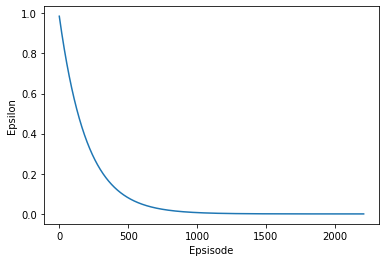

In [7]:
#initialising the environment and agent
env = gridEnvironment(stochastic=True)
env.reset()
agent = Agent(25, 4)
#learning the grid environment
agent.learn(env)

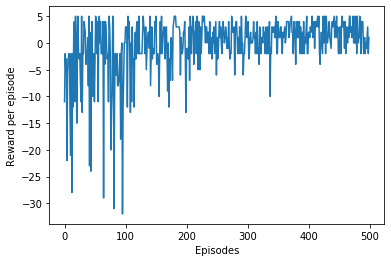

In [8]:
agent.plot_reward()

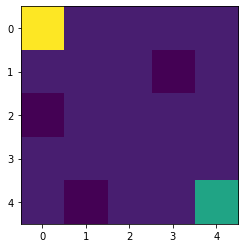

In [9]:
env.render()

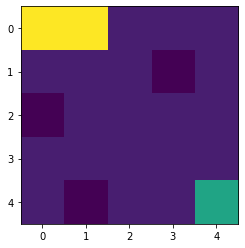

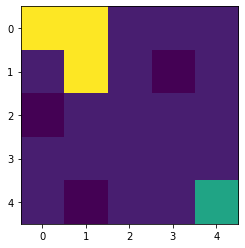

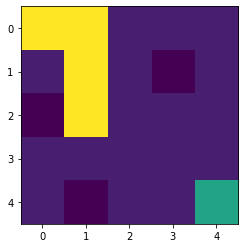

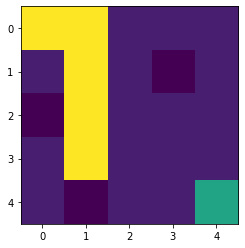

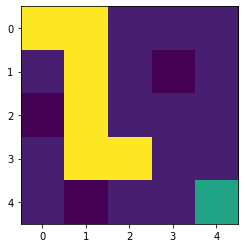

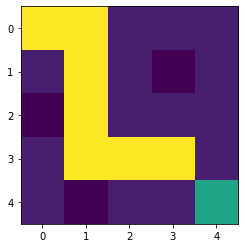

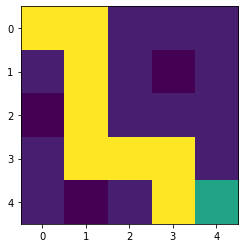

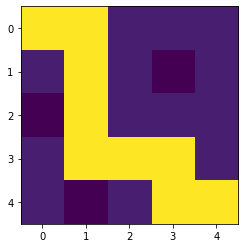

Score:  -2


[0, 1, 6, 11, 16, 17, 18, 23, 24]

In [10]:
agent.GetPath(env)

#### Initialising a deterministic environment and finding the optimal path for getting the maximum reward

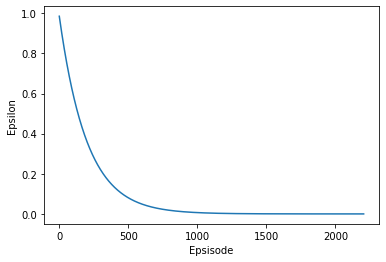

In [11]:
Detenv = gridEnvironment()
Detenv.reset()
agent = Agent(25, 4)
#learning the grid environment
agent.learn(Detenv)

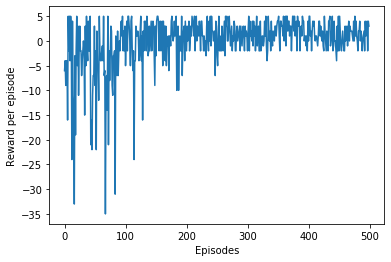

In [12]:
agent.plot_reward()

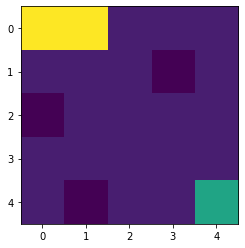

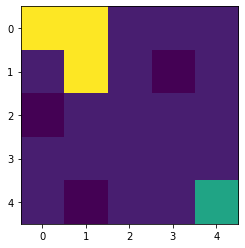

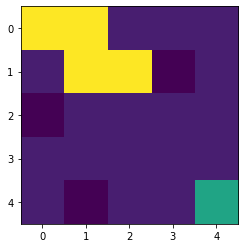

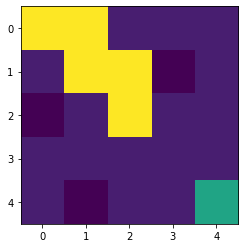

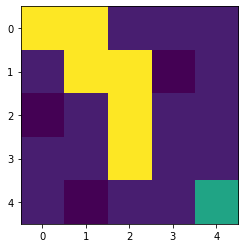

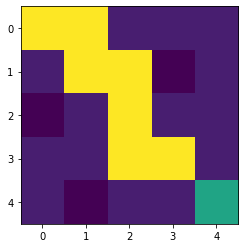

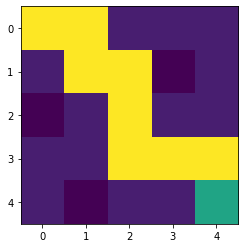

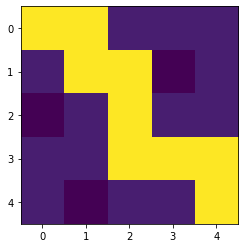

Score:  -2


[0, 1, 6, 7, 12, 17, 18, 19, 24]

In [13]:
agent.GetPath(Detenv)